In [1]:
!pip install pandas
!pip install statsmodels
!pip install matplotlib
!pip install seaborn
!pip install numpy

     |████████████████████████████████| 9.9 MB 4.4 MB/s eta 0:00:01     |████████████████████████████████| 9.9 MB 4.4 MB/s 
     |████████████████████████████████| 15.3 MB 42.6 MB/s eta 0:00:01
     |████████████████████████████████| 9.5 MB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 27.4 MB 25.9 MB/s eta 0:00:01
     |████████████████████████████████| 231 kB 53.8 MB/s eta 0:00:01
     |████████████████████████████████| 10.3 MB 4.0 MB/s eta 0:00:01�██████▊         | 7.3 MB 4.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 34.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 44.1 MB/s eta 0:00:01
     |████████████████████████████████| 285 kB 4.2 MB/s eta 0:00:01


In [2]:
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [38]:
# df = pd.read_excel('IDD_To_Train.xlsx')
df = pd.read_csv('IDDROI_AggregatedData-R2-Month-2020.csv')

In [39]:
df

,DateModified,Country,Adobe_Unique Visitors,Adobe_Engaged Visits,Utilization_Tests,SearchTrend_Value,Email_Opens,Sales_Calls,Utilization_MemberCount
0,1/1/2020,Belgium,679,130,236007,14602925,60,45,65
1,1/1/2020,France,4731,1355,375399,99868472,55056,833,61
2,1/1/2020,Germany,4004,682,449344,124838074,14095,194,95
3,1/1/2020,United Kingdom,6240,1917,167730,219950675,22504,251,14
4,1/1/2020,Portugal,393,80,10342,15906866,1966,179,4
...,...,...,...,...,...,...,...,...,...
187,12/1/2020,Portugal,1689,580,7030,17232439,155,225,2
188,12/1/2020,Spain,4128,2332,100859,70599715,15539,854,38
189,12/1/2020,Sweden,1950,655,69281,19592574,55,68,29
190,12/1/2020,Switzerland,6316,3185,64384,13241572,204,67,28


In [40]:
#Model some type of nonlinearity
df['drdr'] = df['Utilization_MemberCount']*df['Utilization_MemberCount']
df['log2dr'] = np.log2(df['Utilization_MemberCount'])

In [41]:
#Scale SearchTrend_Value
df['SearchTrend_Modified'] = df['SearchTrend_Value']/1000

In [42]:
#Fix any place where the log2 is -infinity (log of 0)
df.loc[df['log2dr']==-np.inf,'log2dr'] = 0

In [43]:
# train = df[['YrMth','CityState','AffectedPop','UV','NumReps','Staffed','Revenue','Calls','Tenure']]
# X = train[['YrMth','CityState','AffectedPop','UV','NumReps','Staffed','Calls','Tenure']]
# X_ols = train[['AffectedPop','UV','NumReps','Staffed']]
train = df[['DateModified','Country',"Adobe_Engaged Visits",'SearchTrend_Modified','Email_Opens','Sales_Calls','Utilization_MemberCount','drdr','log2dr','Utilization_Tests']]
X = train[['DateModified','Country',"Adobe_Engaged Visits",'SearchTrend_Modified','Email_Opens','Sales_Calls','Utilization_MemberCount','drdr','log2dr']]
X_ols = train[["Adobe_Engaged Visits",'SearchTrend_Modified','Email_Opens','Sales_Calls','Utilization_MemberCount','drdr','log2dr']]
y = train['Utilization_Tests']

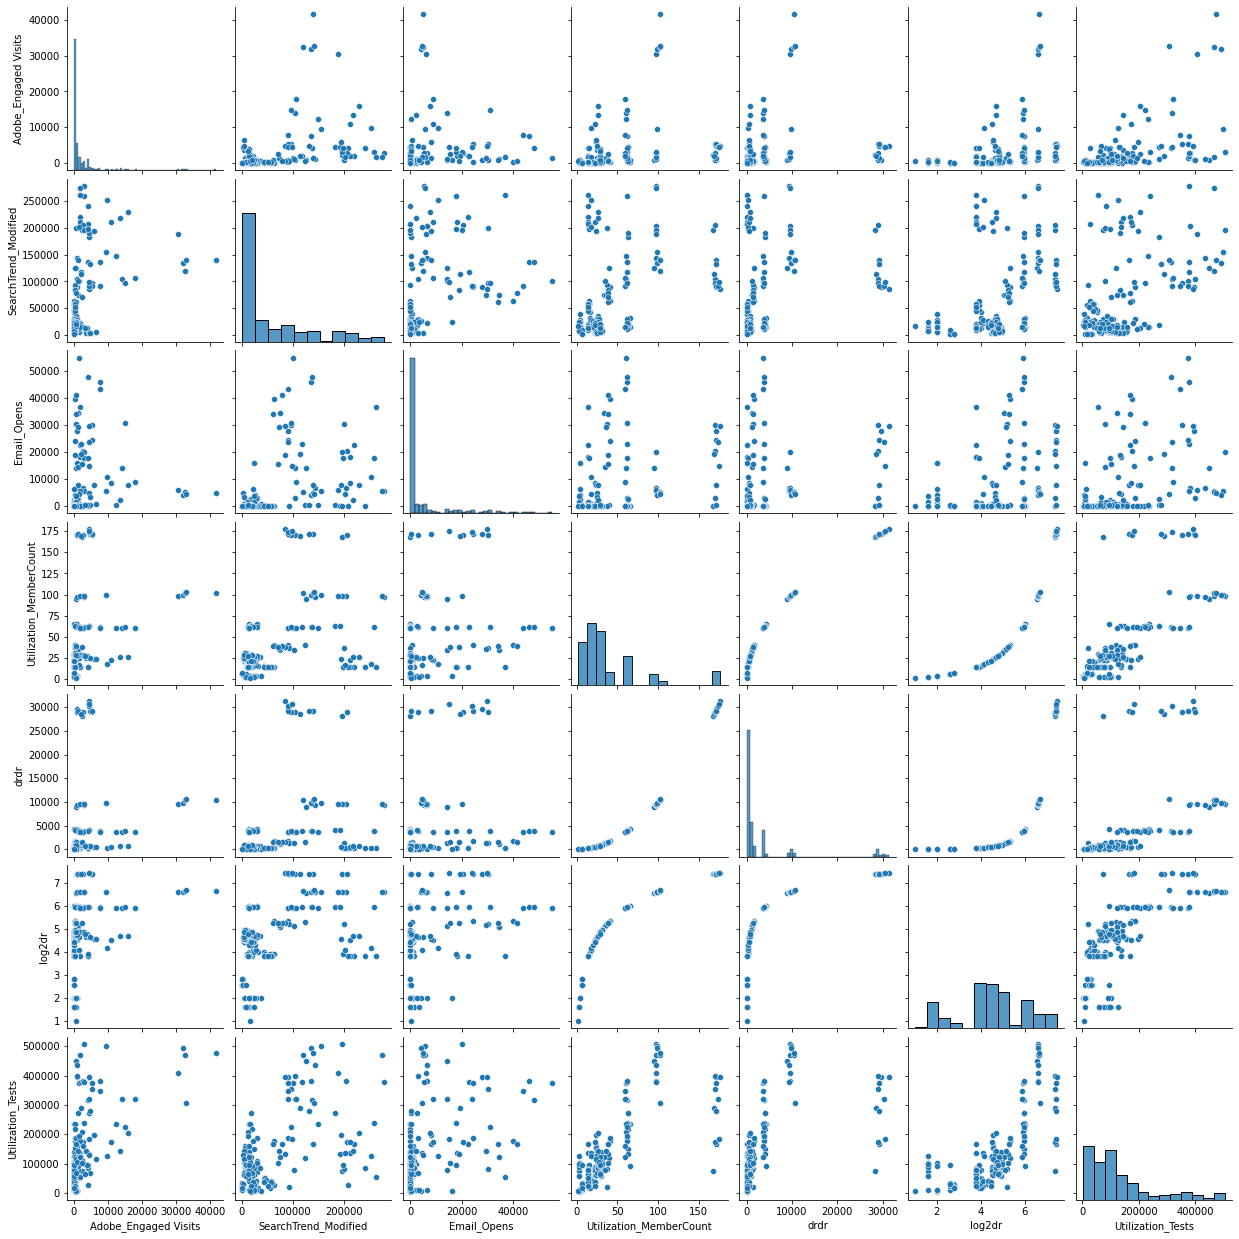

In [45]:
#Look at interactions between the variables. Not very many great relationships except definitely some interactions between # of Drs and Revenue
sns.pairplot(train[["Adobe_Engaged Visits",'SearchTrend_Modified','Email_Opens','Utilization_MemberCount','drdr','log2dr','Utilization_Tests']])
plt.show()

In [46]:
!pip install sklearn

In [47]:
#Split the data into train/test datasets and get ready to build a random forest

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

rf = RandomForestRegressor()
X = pd.get_dummies(X)

x_train, x_test, y_train, y_test = train_test_split(X,y)

In [48]:
#Train an OLS regression on the original dataset (NOT INCLUDING dr squared or log dr created columns

train_test_cols = ["Adobe_Engaged Visits",'SearchTrend_Modified','Email_Opens','Sales_Calls','Utilization_MemberCount','drdr','log2dr']
x_train_all = sm.tools.add_constant(X[train_test_cols])
x_train_orig = sm.tools.add_constant(X[train_test_cols[:-2]])
mod = sm.GLS(y, x_train_orig)
res = mod.fit()
# res = mod.fit_regularized(alpha=0.1)

x_test_gls = sm.tools.add_constant(X[train_test_cols[:-2]])
y_predict_ols = res.predict(x_test_gls)
print(res.summary())

                            GLS Regression Results                            
Dep. Variable:      Utilization_Tests   R-squared:                       0.703
Model:                            GLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     88.11
Date:                Tue, 04 May 2021   Prob (F-statistic):           3.63e-47
Time:                        16:56:00   Log-Likelihood:                -2402.8
No. Observations:                 192   AIC:                             4818.
Df Residuals:                     186   BIC:                             4837.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    3

In [49]:
#Train an OLS regression on the modified dataset (INCLUDING dr squared or log dr created columns

train_test_cols = ["Adobe_Engaged Visits",'SearchTrend_Modified','Email_Opens','Sales_Calls','Utilization_MemberCount','drdr','log2dr']
x_train_all = sm.tools.add_constant(x_train[train_test_cols])
x_train_orig = sm.tools.add_constant(x_train[train_test_cols[:-2]])
mod = sm.GLS(y_train, x_train_all)
res = mod.fit()
# res = mod.fit_regularized(alpha=0.1)

x_test_gls = sm.tools.add_constant(x_test[train_test_cols])
y_predict_ols = res.predict(x_test_gls)
print(res.summary())

                            GLS Regression Results                            
Dep. Variable:      Utilization_Tests   R-squared:                       0.828
Model:                            GLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     93.28
Date:                Tue, 04 May 2021   Prob (F-statistic):           9.25e-49
Time:                        16:56:11   Log-Likelihood:                -1765.3
No. Observations:                 144   AIC:                             3547.
Df Residuals:                     136   BIC:                             3570.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    9

In [50]:
#Fit the random forest and predict the values for the test dataset

rf.fit(x_train,y_train)
y_predict_rf = rf.predict(x_test)

In [51]:
#Which variables are most important for the random forest? Number of doctors is the strongest predictor
importances = pd.DataFrame(list(zip(*[x_train.columns,rf.feature_importances_])),columns=['variable','importance'])
importances.sort_values('importance',ascending=False)

,variable,importance
5,drdr,0.263828
4,Utilization_MemberCount,0.225462
6,log2dr,0.185333
3,Sales_Calls,0.122159
2,Email_Opens,0.056598
1,SearchTrend_Modified,0.054641
26,Country_Germany,0.038437
0,Adobe_Engaged Visits,0.011061
29,Country_Norway,0.007766
10,DateModified_12/1/2020,0.007223


In [52]:
#Import functions to calculate metrics from sklearn to make it easier to ensure I'm calculating it correctly
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [53]:
mse_rf = mean_squared_error(y_test, y_predict_rf)
mae_rf = mean_absolute_error(y_test, y_predict_rf)
r2_rf = r2_score(y_test, y_predict_rf)
mse_ols = mean_squared_error(y_test, y_predict_ols)
mae_ols = mean_absolute_error(y_test, y_predict_ols)
r2_ols = r2_score(y_test, y_predict_ols)

print(f'OLS\nMSE: {mse_ols:0,.0f}\t\tMAE: {mae_ols:0,.1f}\t\tR-Squared: {r2_ols:0.3f}')
print()
print(f'Random Forest\nMSE: {mse_rf:0,.0f}\t\tMAE: {mae_rf:0,.1f}\t\tR-Squared: {r2_rf:0.3f}')

OLS
MSE: 2,964,160,205		MAE: 40,745.0		R-Squared: 0.774

Random Forest
MSE: 1,373,420,497		MAE: 26,850.3		R-Squared: 0.895


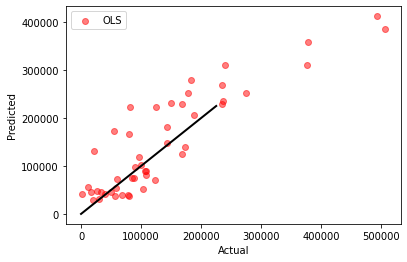

In [54]:
#How closely to the y=x line do the OLS predictions run?
plt.scatter(y_test, y_predict_ols, alpha=0.5, c='r', label='OLS')
plt.plot([0, 225000], [0, 225000], color='k', linestyle='-', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.show()

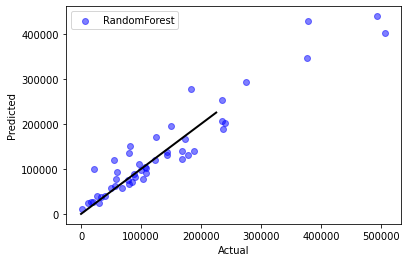

In [55]:
#How closely to the y=x line do the random forest predictions run?
plt.scatter(y_test, y_predict_rf, alpha=0.5, c='b', label='RandomForest')
plt.plot([0, 225000], [0, 225000], color='k', linestyle='-', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.show()